In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
import pandas as pd
import datetime as dt
import numpy_financial as npf
import yfinance as yf
from scipy.optimize import minimize

plt.style.use("ggplot")

# <font face="gotham" color="purple">Bond Valuation</font>

Here is a general logic of Bond Valuation:
Adding up all present values of expected cash flows to equal the par value of the security.

Three procedures:
1. Estimate the cash flow (It's simple if you hold treasury bills or bonds, because they are fixed. It's way much more complicated for structured products like Mortgage-Backed Securities)
2. Which discount rate to use? (Require return = risk-free rate + risk premium)
3. Calculate the present values of all cash flows.

## <font face="gotham" color="purple">Zero Coupon Bond</font>

Zero coupon bond returns you principal amount (face value) after certain period of time, no other cash payment is made. 

The most common zero coupon bond is US treasury bill, you buy the bill with a discounted price, for instance the par value is $\$1000$, you pay $\$950$ today and receives the par value $\$1000$ one year later.

In reality, treasury bills has different maturities, such as 4 week, 8 weeks or the longest 52 weeks.

In [2]:
class ZeroCouponBonds:

    def __init__(self, principal, maturity, discount_rate):
        self.principal = principal
        self.maturity = maturity  # date to maturity
        self.discount_rate = discount_rate  # risk-free interest rate

    def calculate_pv(self):
        return self.principal / (1 + self.discount_rate) ** self.maturity

In [3]:
bond = ZeroCouponBonds(1000, 3, 0.04)

In [4]:
bond.calculate_pv()

888.9963586709148

In [5]:
discount_rate_array = np.linspace(0.01, 0.1)
pv_array = []
for i in discount_rate_array:
    pv_array.append(ZeroCouponBonds(1000, 3, i).calculate_pv())

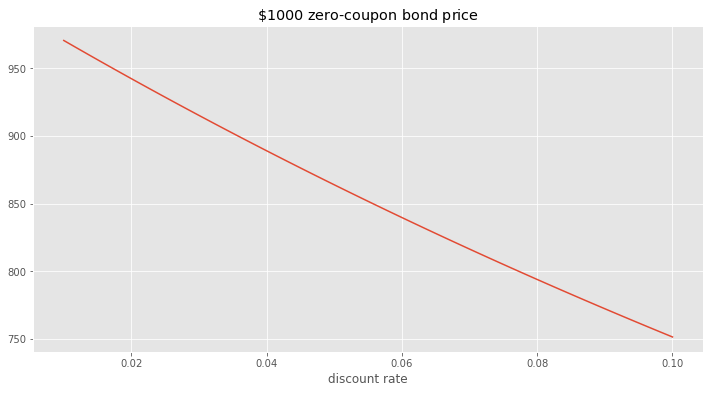

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(discount_rate_array, pv_array)
ax.set_title("$\$1000$ zero-coupon bond price")
ax.set_xlabel("discount rate")
plt.show()

# <font face="gotham" color="purple">Coupon Bond</font>

Coupon bonds are the one paying regular coupons till maturity. The pricing formula is 

$$
P= \sum_{t=1}^n \frac{C_t}{(1+r)^t}+\frac{B}{(1+r)^n}
$$

where $C$ is coupon, B is the par value, n is the maturity.

3 year maturity, coupon rate $10\%$, annual payment, par value $\$1000$, discount rate (YTM) is $4\%$.

In [7]:
class CouponBond:

    def __init__(self, principal, coupon_rate, maturity, discount_rate):
        self.principal = principal
        self.coupon_rate = coupon_rate
        self.maturity = maturity
        self.discount_rate = discount_rate

    def calculate_pv(self, x, n):
        return x / (1 + self.discount_rate) ** n

    def calculate_bond_price(self):
        price = 0
        for t in range(1, self.maturity + 1):
            price = price + self.calculate_pv(self.principal * self.coupon_rate, t)
        price = price + self.calculate_pv(self.principal, self.maturity)
        return price

In [8]:
bond = CouponBond(1000, 0.1, 3, 0.08)

In [9]:
bond.calculate_bond_price()

1051.5419397449573

In [10]:
discount_rate_array = np.linspace(0.01, 0.15)
pv_array = []
for i in discount_rate_array:
    pv_array.append(CouponBond(1000, 0.1, 3, i).calculate_bond_price())

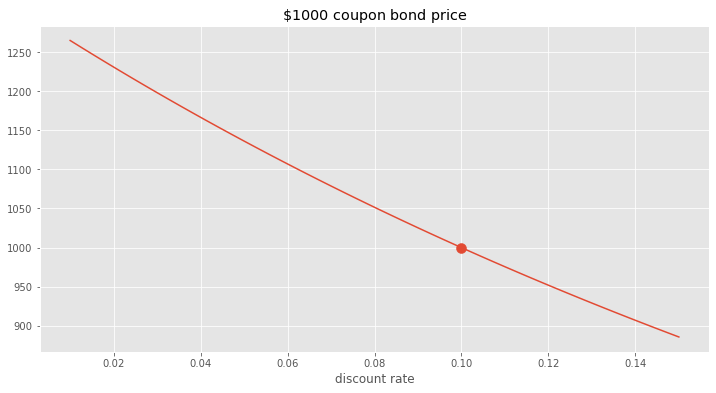

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(discount_rate_array, pv_array)
ax.set_title("$\$1000$ coupon bond price")
ax.set_xlabel("discount rate")
ax.scatter(0.1, 1000, s=100)
plt.show()

From the chart, we know that if discount rate equals coupon rate, in this case $10\%$, it's called **par bond**. If the price is larger than face value, it is **premium bond**, vice verse **discount bond**.

# <font face="gotham" color="purple">Portfolio Management</font>

If you are not a single asset trader, you will end up constructing your portfolio sooner or later. In the view of portfolio management, the risk of single type of asset is not a major concern anymore, rather the risk of portfolio, e.g. you might need to consider have derivatives in your portfolios too.

1. Planning
* State your investment objectives and constraints. (Institutions usually use Investment Policy Statement)</br>
* Review your objective benchmark regularly</br>

2. Execution
* Asset allocation</br>
* Security Analysis</br>
* Portfolio construction</br>

3. Feedback
* Monitor and rebalance portfolio</br>
* Measure portfolio performance</br>

# <font face="gotham" color="purple"> Performance Measuring</font>

Two methods of measuring portfolio's performance.

## <font face="gotham" color="purple"> Time-Weight Rate of Return</font>

Basically it's annualized geometric mean.

Suppose you hold a portfolio for 3 years, at the end of first year the return is 12%, second year 2%, third year 7%. 

The geometric mean function can return a TWRR directly, if the holding period is long than 1 year.

In [12]:
sp.stats.gmean([12, 2, 7])

5.517848352762241

Now suppose you hold a portfolio for 1 year, at the end of first season the return is 1%, the second season 4%, the third season -5%, the forth season 8%.

In [13]:
np.prod([1.01, 1.04, 0.95, 1.08]) - 1

0.07771039999999996

The general formula is 
$$
\text{TWRR} = \left[\prod_{i=1}^N(1+\text{HPR}_i)\right]^{1/n}-1
$$

TWRR measures the compound rate of return, where $n$ is number of years, $N$ the number of periods, $\text{HPR}$ means _holding period return_.

As a reminder, for audiences familiar with another measurement *Compound Annual Growth Rate* $\text{CAGR}$
$$
C A G R=\left[\left(\frac{E V}{B V}\right)^{1/n}-1\right]\times 100
$$
where:
$E V=$ Ending value<br>
$B V=$ Beginning value<br>
$n=$ Number of years


Both are geometric means, but $\text{TWRR}$ measures returns of every period.

### <font face="gotham" color="purple"> Example of TWRR </font>

You bought a share of a mutual fund for $\$100$ at $t=0$, another share at $\$113$ at $t=1$, also you receive dividend $\$4$ at $t=1$, $\$7$ at $t=2$ per share.Then you redeem both shares for $\$120$ at $t=2$.

Calculate TWRR.

In [14]:
fund = {"price": [100, 113, 120], "dividend": [0, 4, 7]}
fund = pd.DataFrame(fund)
fund

,price,dividend
0,100,0
1,113,4
2,120,7


In [15]:
HPR_1 = (113 + 4) / 100 - 1
HPR_2 = (120 * 2 + 7 * 2) / (113 * 2) - 1

In [16]:
np.sqrt((1 + HPR_1) * (1 + HPR_2)) - 1

0.14671520100345292

## <font face="gotham" color="purple"> Money-Weight Rate of Return</font>

Basically annualized IRR.

### <font face="gotham" color="purple"> Example of MWRR </font>

You bought a share of a mutual fund for $\$100$ at $t=0$, another share at $\$113$ at $t=1$, also you receive dividend $\$4$ at $t=1$, $\$7$ at $t=2$ per share.Then you redeem both shares for $\$120$ at $t=2$.

Calculate MWRR.

The key of MWRR is to identify _net cash flow_ for each period, then calculate IRR.

In [17]:
npf.irr([-100, -113 + 4, 120 * 2 + 7 * 2])

0.13934705449916107

To summarize, MWRR takes account of cash flow, TWRR does not.

# <font face="gotham" color="purple"> Modern Portfolio Theory</font>

MPT states that investors can construct optimal portfolios offering maximum possible expected return for a given risk level.

Assumption:
1. Return of assets are normally distributed.
2. Investors are risk-averse. (Higher return, higher risks.)
3. Investors are only long positions only.

## <font face="gotham" color="purple"> Efficiency Frontier</font>

## <font face="gotham" color="purple"> Definition of Portfolio Return and Volatility</font>

Commonly the MPT is illustrated by matrices. Define $\mathbf{R}$ and $\mathbf{w}$

$$
\mathbf{R}=\left[\begin{array}{c}
R_1 \\
R_2 \\
R_3
\end{array}\right], \quad \mathbf{w}=\left[\begin{array}{l}
w_1 \\
w_2 \\
w_3
\end{array}\right]
$$
where $R_i$ represents the return of asset $i$; $w_i$ the weight of asset $i$

The expected return and covariance matrix of return is
$$
E[\mathbf{R}]=\left[\begin{array}{l}
E\left[R_1\right] \\
E\left[R_2\right] \\
E\left[R_3\right]
\end{array}\right]=\left[\begin{array}{c}
\mu_1 \\
\mu_2 \\
\mu_3
\end{array}\right]=\boldsymbol{\mu}
$$

$$
\begin{aligned}
\operatorname{var}(\mathbf{R}) & =\left[\begin{array}{ccc}
\operatorname{var}\left(R_1\right) & \operatorname{cov}\left(R_1, R_2\right) & \operatorname{cov}\left(R_1, R_3\right) \\
\operatorname{cov}\left(R_2, R_1\right) & \operatorname{var}\left(R_2\right) & \operatorname{cov}\left(R_2, R_3\right) \\
\operatorname{cov}\left(R_3, R_1\right) & \operatorname{cov}\left(R_3, R_2\right) & \operatorname{var}\left(R_3\right)
\end{array}\right] \\
& =\left[\begin{array}{ccc}
\sigma_1^2 & \sigma_{1, 2} & \sigma_{1, 3} \\
\sigma_{1,2} & \sigma_2^2 & \sigma_{2,3} \\
\sigma_{1,3} & \sigma_{2,3} & \sigma_3^2
\end{array}\right]=\mathbf{\Sigma} 
\end{aligned}
$$

The portfolio return is obtained by inner product of $\mathbf{w}$ and $\mathbf{R}$ 

$$
R_{p}=\mathbf{x}^{T} \mathbf{R}=\left[w_1, w_2, w_3\right]\left[\begin{array}{c}
R_A \\
R_B \\
R_C
\end{array}\right]=x_1 R_1+x_2 R_2+x_3 R_3
$$
where $R_p$ represents portfolio return. Similarly, the expected portfolio return is
$$
w_1 \mu_1+w_2 \mu_2+w_3 \mu_3
$$

The variance of the portfolio is
$$
\sigma_{p}^2=\operatorname{var}\left[\mathbf{w}^{T} \mathbf{R}\right]=\mathbf{w}^{T} \Sigma \mathbf{w}=\left[x_1, x_2, x_3\right]\left[\begin{array}{ccc}
\sigma_1^2 & \sigma_{1,2} & \sigma_{1,3} \\
\sigma_{1,2} & \sigma_2^2 & \sigma_{2,3} \\
\sigma_{1,3} & \sigma_{2,3} & \sigma_3^2
\end{array}\right]\left[\begin{array}{l}
x_1 \\
x_2 \\
x_3
\end{array}\right]
$$

This is a standard quadratic form, for more details, check <a href='https://nbviewer.org/github/WeijieChen-MacroAnalyst/Linear_Algebra_With_Python/blob/master/Chapter%2017%20-%20Symmetric%20Matrices%20%2C%20Quadratic%20Form%20and%20Cholesky%20Decomposition.ipynb'>quadratic form</a> and <a href='https://nbviewer.org/github/WeijieChen-MacroAnalyst/Linear_Algebra_With_Python/blob/master/Chapter%2019%20-%20Multivariate%20Normal%20Distribution.ipynb'>multivariate normal distribution</a>.

## <font face="gotham" color="purple"> Sharpe Ratio</font>

Sharpe Ratio 
$$SR=\frac{R_p-R_f}{\sigma_p}$$
where:
$R_p=$ return of portfolio</br>
$R_f=$ risk-free rate</br>
$\sigma_p=$ standard deviation of the portfolio's excess return

## <font face="gotham" color="purple">Retrieve Data</font>

In [18]:
stocks = ["AMZN", "HD", "MRNA", "TSLA", "LULU"]
start_date = "2015-01-01"
end_date = dt.datetime.today()

In [19]:
def download_data(stocks, dropna):
    # dropna decides if you want to drop all NaN values
    stock_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)["Close"]
    if dropna == True:
        df = pd.DataFrame(stock_data).dropna()
    else:
        df = pd.DataFrame(stock_data)
    return df

In [20]:
df = download_data(stocks, dropna=True)
df.head()

,AMZN,HD,MRNA,TSLA,LULU
Date,,,,,
2018-12-07,81.456497,157.018402,18.600000,23.864668,113.870003
2018-12-10,82.051498,156.018799,18.799999,24.343332,115.010002
2018-12-11,82.162003,156.491348,18.010000,24.450666,116.849998
2018-12-12,83.177002,158.308792,18.680000,24.440001,122.650002
2018-12-13,82.918999,157.999847,18.760000,25.119333,120.199997


In [21]:
def plot_data(size, data, title):
    # choose the size of the figure [w, h]
    data.plot(figsize=(size[0], size[1]), title=title)
    plt.show()

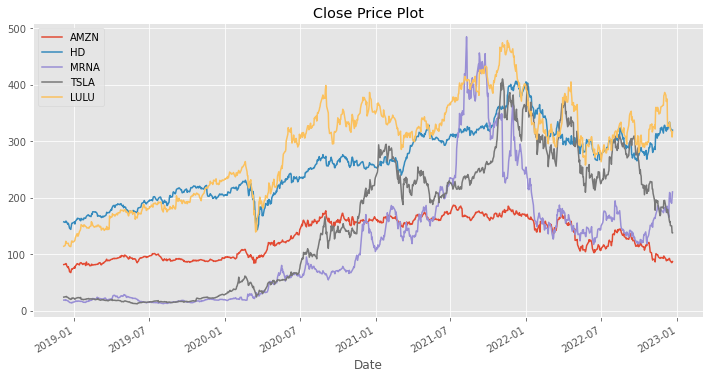

In [22]:
plot_data([12, 6], df, title="Close Price Plot")

In [23]:
def cal_log_return(data):
    return (np.log(data) - np.log(data.shift())).dropna()

In [24]:
log_ret_daily = cal_log_return(df)

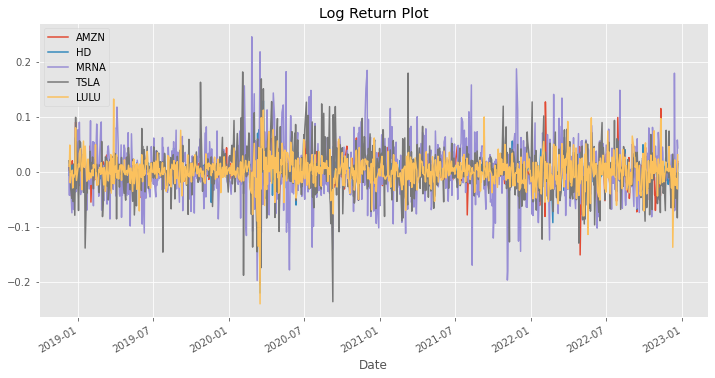

In [25]:
plot_data([12, 6], log_ret_daily, title="Log Return Plot")

## <font face="gotham" color="purple"> Calculate Expected Return and Volatility</font>

In [26]:
# assume the average trading days in a year is 252
num_trading_days = 252

In [27]:
def cal_statistics(returns):
    # mean of annual return
    print(returns.mean() * num_trading_days)

In [28]:
cal_statistics(log_ret_daily)

AMZN    0.015658
HD      0.175918
MRNA    0.600671
TSLA    0.434058
LULU    0.253493
dtype: float64


In [29]:
weights = np.array([0.2, 0.1, 0.4, 0.1, 0.1])

$$
\mu = \sum_i w_i \mu_i
$$
where $\mu$ is expected portfolio return, $w$ is the weight, $\mu_i$ is the expected rate of return on a specific asset.

$$
\mathbf{w}^{T} \Sigma \mathbf{w}
$$

In [30]:
def show_mean_var(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * num_trading_days
    portfolio_volatility = np.dot(
        weights.T, np.dot(returns.cov() * num_trading_days, weights)
    )
    print("portfolio return: {}".format(portfolio_return))
    print("portfolio volatility: {}".format(portfolio_volatility))
    return portfolio_return, portfolio_volatility

In [31]:
show_mean_var(log_ret_daily, weights)

portfolio return: 0.32974689639002347
portfolio volatility: 0.1488279347101603


(0.32974689639002347, 0.1488279347101603)

## <font face="gotham" color="purple"> Simulate Portfolios</font>

In [32]:
num_portfolio = 5000


def gen_portfolio(returns, stocks):

    portfolio_weights = []
    portfolio_means = []
    portfolio_volatilities = []

    for i in range(num_portfolio):
        w = np.random.rand(len(stocks))
        w = w / np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * num_trading_days)
        portfolio_volatilities.append(
            np.sqrt(np.dot(w.T, np.dot(returns.cov() * num_trading_days, w)))
        )
    return (
        np.array(portfolio_weights),
        np.array(portfolio_means),
        np.array(portfolio_volatilities),
    )

In [33]:
portfolio_weights, portfolio_means, portfolio_volatilities = gen_portfolio(
    log_ret_daily, stocks
)

In [34]:
plt.rcParams["axes.grid"] = (
    False  # this is unnecessary, but without it, a bug warning will be triggered
)


def portfolio_scatter(returns, volatilities):
    fig, ax = plt.subplots(figsize=(12, 6))
    mpt = ax.scatter(
        volatilities, returns, c=returns / volatilities
    )  # actually we didn't use risk-free rate as reference for SR
    ax.set_xlabel("Expected Volatilities")
    ax.set_ylabel("Expected Returns")
    ax.grid()
    fig.colorbar(mpt, label="Sharpe Ratio")
    plt.show()

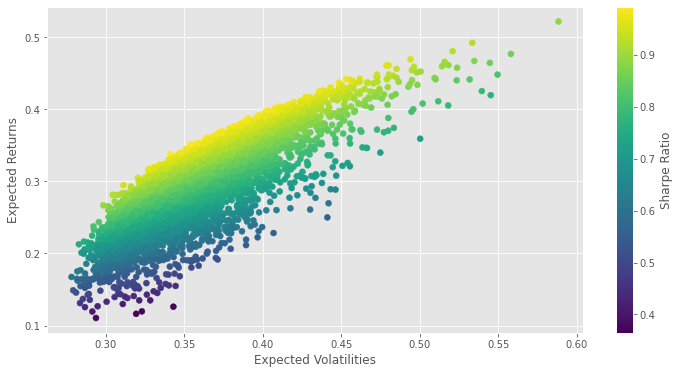

In [35]:
portfolio_scatter(portfolio_means, portfolio_volatilities)

## <font face="gotham" color="purple"> Global Minimum Variance Portfolio</font>

For demonstrating purpose, denote the weight of global minimum variance of $n$ assets portfolio as $\mathbf{w}_g=(w_{1,g},w_{2,g},w_{3,g}, ..., w_{n,g})$

$$
\begin{gathered}
\min _{\mathbf{w}} \mathbf{w}^{T} \Sigma \mathbf{w}\\
\text { s.t. } \sum_{i=1}^n w_{i,g}=1 
\end{gathered}
$$

You can obtain F.O.C by performing partial derivative on the Lagrangian form, however it can be absurdly tedious, therefore we skill this step. 

In short, to arrange the F.O.C. in matrix form, we obtain
$$
\left[\begin{array}{cc}
2 \boldsymbol{\Sigma} & \mathbf{1} \\
\mathbf{1}^{T} & 0
\end{array}\right]\left[\begin{array}{c}
\mathbf{w} \\
\lambda
\end{array}\right]=\left[\begin{array}{l}
\mathbf{0} \\
1
\end{array}\right]
$$

where $\boldsymbol{\Sigma}$ is covariance matrix, $\mathbf{1}$ and $\mathbf{0}$ is a $n-1$ vector of $1$'s and $0$'s.

The solution is straightforward in linear algebra form

$$
\left[\begin{array}{c}
\mathbf{w} \\
\lambda
\end{array}\right]=\left[\begin{array}{cc}
2 \boldsymbol{\Sigma} & \mathbf{1} \\
\mathbf{1}^{T} & 0
\end{array}\right]^{-1}\left[\begin{array}{l}
\mathbf{0} \\
1
\end{array}\right]
$$

## <font face="gotham" color="purple"> Efficient Portfolio</font>

The formulation of portfolio optimization follows a standard microeconomic optimization duality, i.e. maximize the expected return subject to a certain risk, or minimize the risk subject to a certain rate of expected rate. 

$$
\begin{aligned}
\max _{\mathbf{x}} \mu_p & =\mathbf{w}^{T} \boldsymbol{\mu}  \\
\text { s.t. }\mathbf{w}^{T} \boldsymbol{\Sigma} \mathbf{w}&=\sigma_{p, 0}^2 \text { and } \mathbf{w}^{T} \mathbf{1}=1
\end{aligned}
$$

$$
\begin{aligned}
\min _{\mathbf{w}} \sigma_{p, w}^2 & =\mathbf{w}^{T} \boldsymbol{\Sigma} \mathbf{w}  \\
\text { s.t. }\mathbf{w}^{T} \boldsymbol{\mu}&=\mu_{p, 0}, \text { and } \mathbf{w}^{T} \mathbf{1}=1
\end{aligned}
$$

where $\sigma_{p,0}^2$ is the target portfolio variance and $\mu_{p, 0}$ is the target portfolio expected return.

Theoretically, you can pick any formulation you like, but in practice the latter is more common due to its computational convenience.

The **efficient frontier** is a graph of $\mu_p$ and $\sigma_p$ resembles one side of hyperbola as we have shown above, and is often called the 'Markowitz Bullet'.

Two constraints for two $\lambda$'s, the Lagrangian formulation is
$$
L\left(\mathbf{w}, \lambda_1, \lambda_2\right)=\mathbf{w}^{T} \boldsymbol{\Sigma} \mathbf{w}+\lambda_1\left(\mathbf{w}^{T} \boldsymbol{\mu}-\mu_{p, 0}\right)+\lambda_2\left(\mathbf{w}^{T} \mathbf{1}-1\right)
$$


The F.O.C.s for a minimum are
$$
\begin{aligned}
& \frac{\partial L\left(\mathbf{w}, \lambda_1, \lambda_2\right)}{\partial \mathbf{w}}=2 \boldsymbol{\Sigma} \mathbf{w}+\lambda_1 \boldsymbol{\mu}+\lambda_2 \mathbf{1}=\mathbf{0} \\
& \frac{\partial L\left(\mathbf{w}, \lambda_1, \lambda_2\right)}{\partial \lambda_1}=\mathbf{w}^{T} \boldsymbol{\mu}-\mu_{p, 0}=0 \\
& \frac{\partial L\left(\mathbf{w}, \lambda_1, \lambda_2\right)}{\partial \lambda_2}=\mathbf{w}^{T} \mathbf{1}-1=0 .
\end{aligned}
$$

We can represent the system of linear equations using matrix as
$$
\left(\begin{array}{ccc}
2 \boldsymbol{\Sigma} & \boldsymbol{\mu} & \mathbf{1} \\
\boldsymbol{\mu}^{\prime} & 0 & 0 \\
\mathbf{1}^{\prime} & 0 & 0
\end{array}\right)\left(\begin{array}{c}
\mathbf{w} \\
\lambda_1 \\
\lambda_2
\end{array}\right)=\left(\begin{array}{c}
\mathbf{0} \\
\mu_{p, 0} \\
1
\end{array}\right)
$$
or
$$
\mathbf{A} \mathbf{z}_w=\mathbf{b}_0,
$$
where
$$
\mathbf{A}=\left(\begin{array}{ccc}
2 \boldsymbol{\Sigma} & \boldsymbol{\mu} & \mathbf{1} \\
\boldsymbol{\mu}^{T} & 0 & 0 \\
\mathbf{1}^{T} & 0 & 0
\end{array}\right), \mathbf{z}_w=\left(\begin{array}{c}
\mathbf{w} \\
\lambda_1 \\
\lambda_2
\end{array}\right) \text { and } \mathbf{b}_0=\left(\begin{array}{c}
\mathbf{0} \\
\mu_{p, 0} \\
1
\end{array}\right)
$$
The solution for $\mathbf{z}_w$ is then
$$
\mathbf{z}_w=\mathbf{A}^{-1} \mathbf{b}_0
$$

## <font face="gotham" color="purple">  Optimization Algorithm</font>

In [36]:
def statistics(weights, returns):
    portfolio_returns = np.sum(returns.mean() * weights) * num_trading_days
    portfolio_volatilities = np.sqrt(
        np.dot(weights, np.dot(returns.cov() * num_trading_days, weights))
    )
    portfolio_sharpe_ratio = portfolio_returns / portfolio_volatilities
    return portfolio_returns, portfolio_volatilities, portfolio_sharpe_ratio

In practice, we could also minimize the negative Sharpe ratio, because $\text{max} f(x) = \text{min} [-f(x)]$

In [37]:
def neg_sharpe(weights, returns):
    return -statistics(weights, returns)[2]  # this is the negative sharpe ratio

Here we use lambda function, as a reminder of expression format
$$
\text{lambda arguments : expression}
$$

In [38]:
def optimize_portfolio(weights, log_returns):
    constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for i in range(len(stocks)))
    return minimize(
        fun=neg_sharpe,
        x0=weights[0],
        args=log_returns,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
    )

In [39]:
def print_optimal_portfolio(optimum, returns):
    print(
        "Optimal portfolio: ", optimum["x"].round(3)
    )  # 'x' is the solution array of OptimizeResult object
    print(
        "Expected return, volatility and SR: ",
        statistics(optimum["x"].round(3), returns),
    )

In [40]:
def plot_optimal_portfolio(optimal, returns, portfolio_returns, portfolio_volatility):
    figure, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(
        portfolio_volatility,
        portfolio_returns,
        c=portfolio_returns / portfolio_volatility,
    )
    ax.scatter(
        statistics(optimal["x"], returns)[1],
        statistics(optimal["x"], returns)[0],
        s=100,
        marker=(5, 1),
    )
    ax.set_xlabel("Expected Volatility")
    ax.set_ylabel("Expected Returns")
    plt.show()

In [41]:
optimum = optimize_portfolio(portfolio_weights, log_ret_daily)
print_optimal_portfolio(optimum, log_ret_daily)

Optimal portfolio:  [0.    0.338 0.303 0.211 0.147]
Expected return, volatility and SR:  (0.3703133225070378, 0.37094113277783103, 0.9983075204788108)


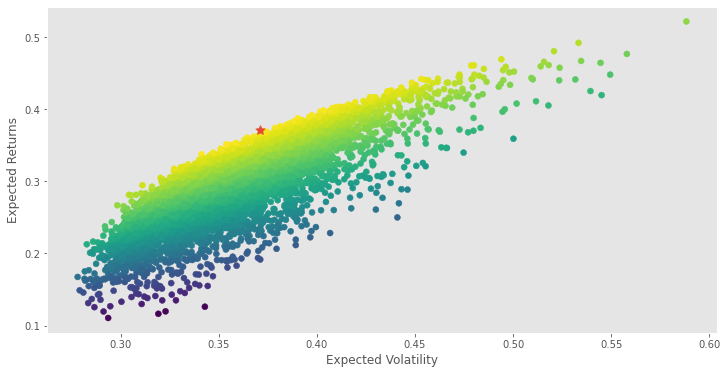

In [42]:
plot_optimal_portfolio(optimum, log_ret_daily, portfolio_means, portfolio_volatilities)